In [2]:
from cobaya.model import get_model
from cobaya.run import run
import yaml
import os
from tqdm import tqdm
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import yaml
from cl_like.theory_vector import posterior
from numpy.linalg import multi_dot
import pyccl as ccl
%config InlineBackend.figure_format = 'retina'

# Read in the yaml file
config_fn = 'test.yml'
with open(config_fn, "r") as fin:
    info = yaml.load(fin, Loader=yaml.FullLoader)

# Get the mean proposed in the yaml file for each parameter
p0 = {}
for p in info['params']:
     if isinstance(info['params'][p], dict):
         if 'ref' in info['params'][p]:
             p0[p] = info['params'][p]['ref']['loc']
os.system('mkdir -p ' + info['output'])

print("params_dict = ", p0)
model = get_model(info,debug=False)

loglikes, derived = model.loglikes(p0)
print("chi2 = ", -2 * loglikes[0])

# Run minimizer
updated_info, sampler = run(info,debug=False)
bf = sampler.products()['minimum']
pf = {k: bf[k] for k in p0.keys()}
print("Final params: ")
print(pf)

params_dict =  {'sigma8': 0.81, 'Omega_c': 0.25, 'Omega_b': 0.05, 'h': 0.7, 'n_s': 0.96}
[model] *WARNING* Ignored blocks/options: ['sampler', 'output']
chi2 =  1.2322988416582104
[output] Output to be read-from/written-into folder 'cobaya_out', with prefix 'test'
[minimize] Initializing
[minimize] Starting 1/2 random initial point:
[minimize] {'sigma8': 0.8038143998947106, 'Omega_c': 0.24725799068749638, 'Omega_b': 0.04713401919814068, 'h': 0.6962931674613475, 'n_s': 0.9541303255213469}
[minimize] Starting 2/2 random initial point:
[minimize] {'sigma8': 0.8053667251924153, 'Omega_c': 0.2371764544787714, 'Omega_b': 0.06171076675634156, 'h': 0.6916744085517065, 'n_s': 0.9707759696543273}
[minimize] Finished successfully!
[minimize] *WARNING* Big spread in minima: [0.13859326196894367, 2.716216952164488]
[minimize] -log(likelihood) minimized to 0.138593
[minimize] Parameter values at minimum:
  weight minuslogpost    sigma8   Omega_c   Omega_b         h       n_s minuslogprior minuslogpr

In [3]:
loglikes, derived = model.loglikes(pf)
loglikes

array([-0.13859326])

In [11]:
list(model.parameterization.sampled_params())

['sigma8', 'Omega_c', 'Omega_b', 'h', 'n_s']

In [15]:
# old fisher code
class Fisher:
    def __init__(self,pf,h):
        self.pf = pf
        self.h_fact = h

    # Determine likelihood at new steps
    def fstep(self,param1,param2,h1,h2,signs):
        newp = self.pf.copy()
        newp[param1] = self.pf[param1] + signs[0]*h1
        newp[param2] = self.pf[param2] + signs[1]*h2

        newloglike = model.loglikes(newp,cached=False)

        return -1*newloglike[0]

    # Fisher matrix elements
    def F_ij(self,param1,param2,h1,h2):
        # Diagonal elements
        if param1==param2:
            f1 = self.fstep(param1,param2,h1,h2,(0,+1))
            f2 = self.fstep(param1,param2,h1,h2,(0,0))
            f3 = self.fstep(param1,param2,h1,h2,(0,-1))
            F_ij = (f1-2*f2+f3)/(h2**2)
        # Off-diagonal elements
        else:
            f1 = self.fstep(param1,param2,h1,h2,(+1,+1))
            f2 = self.fstep(param1,param2,h1,h2,(-1,+1))
            f3 = self.fstep(param1,param2,h1,h2,(+1,-1))
            f4 = self.fstep(param1,param2,h1,h2,(-1,-1))
            F_ij = (f1-f2-f3+f4)/(4*h1*h2)

        return F_ij[0]

    # Calculate Fisher matrix
    def calc_Fisher(self):
        #h_fact =  0.5 # stepsize factor
        #h_fact = array[indx]

        # typical variations of each parameter
        typ_var = {"sigma8": 0.1,"Omega_c": 0.5,"Omega_b": 0.2,"h": 0.5,"n_s": 0.2,"m_nu": 0.1}

        theta = list(self.pf.keys())  # array containing parameter names

        # Assign matrix elements
        F = np.empty([len(theta),len(theta)])
        for i in range(0,len(theta)):
            for j in range(0,len(theta)):
                param1 = theta[i]
                param2 = theta[j]
                h1 = self.h_fact*typ_var[param1]
                h2 = self.h_fact*typ_var[param2]
                F[i][j] = self.F_ij(param1,param2,h1,h2)

        return F

    # Determine condition number of Fisher matrix
    def get_cond_num(self):
        cond_num = LA.cond(self.calc_Fisher())
        return cond_num

    # Get errors on parameters
    def get_err(self):
        covar = LA.inv(self.calc_Fisher())  # covariance matrix
        err = np.sqrt(np.diag(covar))  # estimated parameter errors
        return err

In [89]:
step = np.geomspace(1e-5,0.1,30)
fisher_m = []
for i in tqdm(range(0,len(step))):

    h = step[i]
    final_params = Fisher(pf,h)
    fisher = final_params.calc_Fisher()
    fisher_m.append(fisher)
errs = np.zeros((len(step),len(pf)))
for i,FisherM in enumerate(fisher_m):
    covar = LA.inv(FisherM)  # covariance matrix
    errs[i] = np.sqrt(np.diag(covar))

100%|███████████████████████████████████████████| 30/30 [19:18<00:00, 38.60s/it]


In [26]:
step = [0.01,1e-4,0.0008223030652139986,0.055602680347446184]
h = step[0]
final_params = Fisher(p0,h)
fisher = final_params.calc_Fisher()

In [28]:
covar = LA.inv(fisher)  # covariance matrix
np.sqrt(np.diag(covar))

array([0.00104366, 0.00511562, 0.00497515, 0.02895095, 0.00636339])

In [39]:
covar = LA.inv(fisher)  # covariance matrix
err_001 = np.sqrt(np.diag(covar))

In [81]:
# new code
a = posterior('forecast.yml')
# Cosmology parameter
parms = a.pars
# theory part of ccl 
TH = a.theory
data_invc = a.inv_cov

In [83]:
# Function initialize ccl cosmo object to be passed into posterior calculation
def utility_func_ccl(parms):

    Cosmo = ccl.Cosmology(
        Omega_c=parms['Omega_c'], Omega_b=parms['Omega_b'], h=parms['h'], n_s=parms['n_s'],
        sigma8= parms['sigma8'],T_CMB=2.7255,m_nu=parms['m_nu'],transfer_function=TH['transfer_function'],
        matter_power_spectrum=TH['matter_pk'],baryons_power_spectrum=TH['baryons_pk'])

    return(Cosmo)

def five_point_stencil_deriv(parms = a.pars,par_name = 'sigma8',step_factor = 0.01, verbose = False):
        typ_var = {"sigma8": 0.1,"Omega_c": 0.5,"Omega_b": 0.2,"h": 0.5,"n_s": 0.2,"m_nu": 0.1}
    
        step_size = typ_var[par_name]*step_factor

        left_params_1d = parms.copy()
        left_params_1d[par_name] = left_params_1d[par_name] - step_size
        left_params_2d = parms.copy()
        left_params_2d[par_name] = left_params_1d[par_name] - step_size
        
        
        right_params_1d = parms.copy()
        right_params_1d[par_name] = right_params_1d[par_name] + step_size
        right_params_2d = parms.copy()
        right_params_2d[par_name] = right_params_1d[par_name] + step_size
        
        left_1d_cosmo = utility_func_ccl(parms=left_params_1d)
        right_1d_cosmo = utility_func_ccl(parms=right_params_1d)
        left_2d_cosmo = utility_func_ccl(parms=left_params_2d)
        right_2d_cosmo = utility_func_ccl(parms=right_params_2d)
        
        right_1d = a._get_theory(CCL_cosmo = right_1d_cosmo)
        right_2d = a._get_theory(CCL_cosmo = right_2d_cosmo)


        left_1d = a._get_theory(CCL_cosmo = left_1d_cosmo)
        left_2d = a._get_theory(CCL_cosmo = left_2d_cosmo)
        
        dcl_dparam = (left_2d - 8 * left_1d + 8 * right_1d - right_2d)/ (12 * step_size)
        
        return(dcl_dparam)
        
def get_deriv(parms = a.pars,par_name = 'sigma8',step_factor = 0.01, verbose = False):
    
    typ_var = {"sigma8": 0.1,"Omega_c": 0.5,"Omega_b": 0.2,"h": 0.5,"n_s": 0.2,"m_nu": 0.1}
    
    step_size = typ_var[par_name]*step_factor
    
    left_params = parms.copy()
    left_params[par_name] = left_params[par_name] - step_size

    
    right_params = parms.copy()
    right_params[par_name] = right_params[par_name] + step_size


    left_cosmo = utility_func_ccl(parms=left_params)
    right_cosmo = utility_func_ccl(parms=right_params)

    right = a._get_theory(CCL_cosmo = right_cosmo)
    left = a._get_theory(CCL_cosmo = left_cosmo)
    dCl_dparam = (right-left)/(2 * step_size) 
    if verbose == True:
        print('right loglike: ', a.logp(CCL_cosmo=right_cosmo))
        print('right loglike: ',a.logp(CCL_cosmo=left_cosmo))
    return(dCl_dparam)

In [84]:
parameters = ['sigma8','Omega_c','Omega_b','h','n_s']
def get_fisher(parameters,data_invc,step_factor,verbose = True):
    
    
    F = np.empty([len(parameters),len(parameters)])
    dcl_dparm = {}
    for pars in parameters:
        dcl_dparm[pars] =  five_point_stencil_deriv(parms=parms,par_name= pars,step_factor= step_factor)
    for i,par1 in enumerate(parameters):
        for j,par2 in enumerate(parameters):
                de_par1 = dcl_dparm[par1]
                de_par2 = dcl_dparm[par2]
                F[i,j] =  multi_dot([de_par1,data_invc,de_par2])
                if verbose == True:
                    print(par1,par2)
    return(F)

In [86]:
step = np.geomspace(1e-5,0.1,30)
errs_new = np.zeros((len(step),len(parameters)))
for i,factor in tqdm(enumerate (step)):
    FisherM = get_fisher(parameters,data_invc=data_invc,step_factor=factor,verbose=False)
    covar = LA.inv(FisherM)  # covariance matrix
    errs_new[i] = np.sqrt(np.diag(covar))

30it [03:41,  7.40s/it]


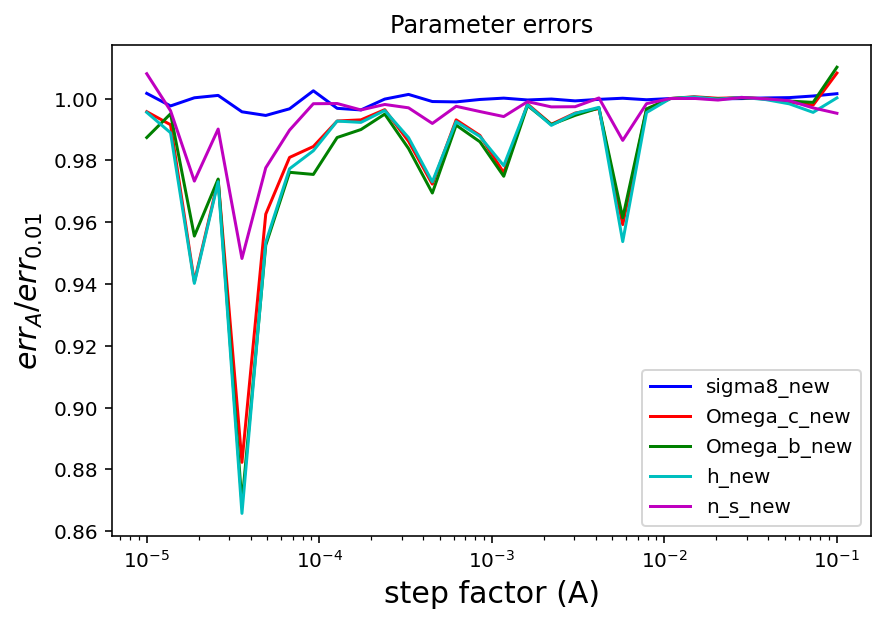

In [87]:
col=['b','r','g','c','m','y']
f1, axes = plt.subplots(1,1,sharex='all')
f1.tight_layout()
axes.set_title('Parameter errors')
for i,labels in enumerate(parameters):  
    axes.semilogx(step,errs_new[:,i]/errs_new[-8,i],color=col[i],label=labels+'_new')
axes.legend()
axes.set_ylabel(r'${err_{A}}/{err_{0.01}}$',fontsize = 15)
axes.set_xlabel('step factor (A)',fontsize = 15);

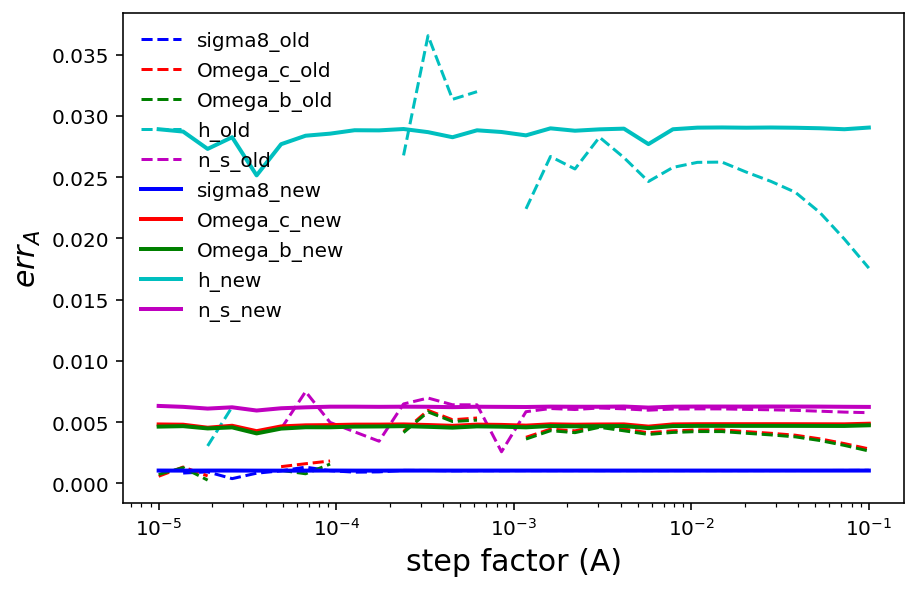

In [108]:
col=['b','r','g','c','m','y']
f1, axes = plt.subplots(1,1,sharex='all',figsize = (7,4.5))
parameters = list(p0.keys())

for i,labels in enumerate(parameters):  
    axes.semilogx(step,errs[:,i],color=col[i],label=labels+'_old',ls = '--')
axes.legend()
axes.set_ylabel(r'${err_{A}}$',fontsize = 15)
axes.set_xlabel('step factor (A)',fontsize = 15);




for i,labels in enumerate(parameters):  
    axes.semilogx(step,errs_new[:,i],color=col[i],label=labels+'_new',linewidth = 2)
axes.legend(frameon = False)
axes.set_ylabel(r'${err_{A}}$',fontsize = 15)
axes.set_xlabel('step factor (A)',fontsize = 15)
f1.savefig('plot/old_new_fisher_compare.eps')

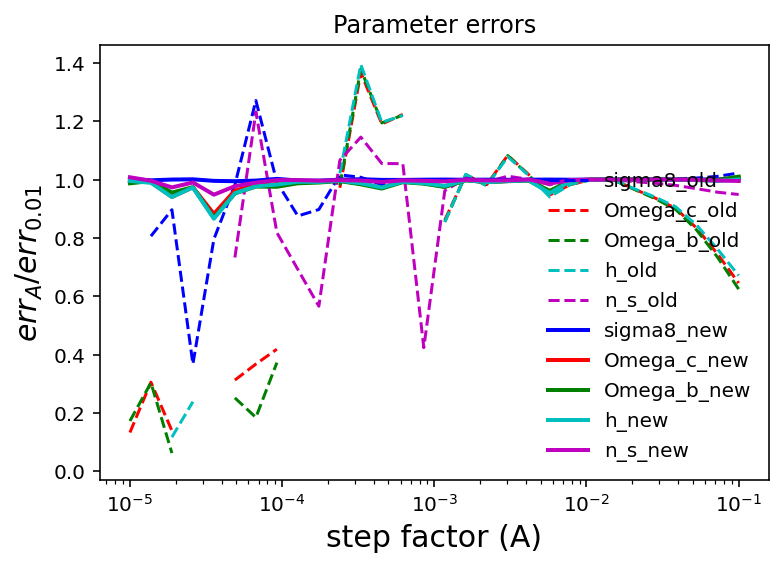

In [109]:
col=['b','r','g','c','m','y']
f1, axes = plt.subplots(1,1,sharex='all',figsize = (6,4))
parameters = list(p0.keys())
axes.set_title('Parameter errors')
for i,labels in enumerate(parameters):  
    axes.semilogx(step,errs[:,i]/errs[-8,i],color=col[i],label=labels+'_old',ls = '--')
axes.legend()
axes.set_ylabel(r'${err_{A}}/{err_{0.01}}$',fontsize = 15)
axes.set_xlabel('step factor (A)',fontsize = 15);




for i,labels in enumerate(parameters):  
    axes.semilogx(step,errs_new[:,i]/errs_new[-8,i],color=col[i],label=labels+'_new',linewidth = 2)
axes.legend(frameon = False,loc = 'lower right')
axes.set_ylabel(r'${err_{A}}/{err_{0.01}}$',fontsize = 15)
axes.set_xlabel('step factor (A)',fontsize = 15);
f1.savefig('plot/old_new_fisher_compare_norm.eps')